<a href="https://colab.research.google.com/github/cmrios2398/GALASA_NLP/blob/main/GALASA_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# **Package Installation**

In [1]:
!pip install transformers
!pip install -U sentence-transformers
!git clone https://github.com/huggingface/transformers.git

from sentence_transformers import SentenceTransformer
from sentence_transformers import models, losses
import sentence_transformers as st
import scipy.spatial
import pickle as pkl
import gc
import matplotlib.pyplot as plt
import torch
import pprint

     |████████████████████████████████| 2.1MB 6.6MB/s 
     |████████████████████████████████| 3.3MB 22.2MB/s 
     |████████████████████████████████| 901kB 38.4MB/s 
     |████████████████████████████████| 81kB 4.3MB/s 
     |████████████████████████████████| 1.2MB 8.4MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-1.1.0-cp37-none-any.whl size=119615 sha256=bb254ffac3cc17afbdbc8dc0f115d6b8fbaee3a853c0387398266bfd8fd6bf4c
  Stored in directory: /root/.cache/pip/wheels/84/cb/21/1066bff3027215c760ca14a198f698bca8fccb92e33e2327eb
Successfully built sentence-transformers
Cloning into 'transformers'...
remote: Enumerating objects: 71775, done.
remote: Counting objects: 100% (437/437), done.
remote: Compressing objects: 100% (276/276), done.
remote: Total 71775 (delta 207), reused 285 (delta 123), pack-reused 71338
Receiving objects: 100% (71775/71775), 54.86 MiB | 23.59 MiB/s, done.
Resolving deltas: 100% (50867/50867), done.


# **Data Retrieval & Initial Sanitisation**

In [2]:
import requests
import pandas as pd

""" makes API get requests for every GitHub Issues post and
creates a list of dictionaries with id, html_url, title and body
to conveniently retrieve necessary data and allow to point at 
each post """

page_no = 1
all_data = []
while True:
  url = 'https://api.github.com/repos/galasa-dev/projectmanagement/issues?state=all&per_page=100&page=' + str(page_no)
  print(url)
  res = requests.get(url)
  for each in res.json():
    entry = {"id" : each["id"], "html_url" : each["html_url"], "title" : each["title"], "body" : each["body"]}
    all_data.append(entry)
  
  page_no += 1

  if len(res.json()) == 0:
    break

https://api.github.com/repos/galasa-dev/projectmanagement/issues?state=all&per_page=100&page=1
https://api.github.com/repos/galasa-dev/projectmanagement/issues?state=all&per_page=100&page=2
https://api.github.com/repos/galasa-dev/projectmanagement/issues?state=all&per_page=100&page=3
https://api.github.com/repos/galasa-dev/projectmanagement/issues?state=all&per_page=100&page=4
https://api.github.com/repos/galasa-dev/projectmanagement/issues?state=all&per_page=100&page=5
https://api.github.com/repos/galasa-dev/projectmanagement/issues?state=all&per_page=100&page=6
https://api.github.com/repos/galasa-dev/projectmanagement/issues?state=all&per_page=100&page=7
https://api.github.com/repos/galasa-dev/projectmanagement/issues?state=all&per_page=100&page=8


**DataFrame Conversion & Duplicate Handling**

In [3]:
test_data_frame = pd.DataFrame(all_data)
test_data_frame.drop_duplicates(['body','title'], inplace=True)

test_data_frame['title'].describe(include='all')

count                                 685
unique                                683
top       RELEASE the HTTP Client Manager
freq                                    2
Name: title, dtype: object

In [4]:
test_data_frame['body'].describe(include='all')

count     685
unique    606
top          
freq       77
Name: body, dtype: object

**Data Inspection**

In [5]:
test_data_frame.head(15)

,id,html_url,title,body
0,875390445,https://github.com/galasa-dev/projectmanagemen...,Add search capability to Galasa Results Run lo...,Add search capability to Galasa Results Run lo...
1,875164874,https://github.com/galasa-dev/projectmanagemen...,NPE is Selenium resource management,04/05/2021 06:56:43.860 ERROR pool-6-thread-2 ...
2,872101215,https://github.com/galasa-dev/projectmanagemen...,Can Galasa be used for IMS screens,"Hi Team,\r\n\r\nI wanted to check if Galasa ca..."
3,871076197,https://github.com/galasa-dev/projectmanagemen...,managers - potential vulnerabilities in snakey...,upgrade to 1.26
4,871074887,https://github.com/galasa-dev/projectmanagemen...,managers - potential vulnerabilities in httpcl...,Upgrade to 4.5.13 or v5
5,871071998,https://github.com/galasa-dev/projectmanagemen...,managers - potential vulnerabilities in google...,A temp directory creation vulnerability exists...
6,871070717,https://github.com/galasa-dev/projectmanagemen...,managers - potential vulnerabilities in common...,upgrade to 2.7
7,871069632,https://github.com/galasa-dev/projectmanagemen...,managers - potential vulnerabilities in common...,upgrade to at least 3.2.2
8,871066989,https://github.com/galasa-dev/projectmanagemen...,managers - potential vulnerabilities in common...,upgrade to 1.13
9,871065998,https://github.com/galasa-dev/projectmanagemen...,managers - vulnerabilities in client-java-7.0.0,"upgrade io.kubernetes.client-java to 9.0.3, 10..."


In [6]:
test_data_frame.describe()

,id
count,6.850000e+02
mean,6.772417e+08
std,1.028836e+08
min,5.193638e+08
25%,6.061776e+08
50%,6.498531e+08
75%,7.447391e+08
max,8.753904e+08


In [7]:
test_data_frame.dropna(inplace=True)
test_data_frame.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 685 entries, 0 to 684
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        685 non-null    int64 
 1   html_url  685 non-null    object
 2   title     685 non-null    object
 3   body      685 non-null    object
dtypes: int64(1), object(3)
memory usage: 26.8+ KB


In [8]:
# checking the first fifteen entries
test_data_frame.head(10)

,id,html_url,title,body
0,875390445,https://github.com/galasa-dev/projectmanagemen...,Add search capability to Galasa Results Run lo...,Add search capability to Galasa Results Run lo...
1,875164874,https://github.com/galasa-dev/projectmanagemen...,NPE is Selenium resource management,04/05/2021 06:56:43.860 ERROR pool-6-thread-2 ...
2,872101215,https://github.com/galasa-dev/projectmanagemen...,Can Galasa be used for IMS screens,"Hi Team,\r\n\r\nI wanted to check if Galasa ca..."
3,871076197,https://github.com/galasa-dev/projectmanagemen...,managers - potential vulnerabilities in snakey...,upgrade to 1.26
4,871074887,https://github.com/galasa-dev/projectmanagemen...,managers - potential vulnerabilities in httpcl...,Upgrade to 4.5.13 or v5
5,871071998,https://github.com/galasa-dev/projectmanagemen...,managers - potential vulnerabilities in google...,A temp directory creation vulnerability exists...
6,871070717,https://github.com/galasa-dev/projectmanagemen...,managers - potential vulnerabilities in common...,upgrade to 2.7
7,871069632,https://github.com/galasa-dev/projectmanagemen...,managers - potential vulnerabilities in common...,upgrade to at least 3.2.2
8,871066989,https://github.com/galasa-dev/projectmanagemen...,managers - potential vulnerabilities in common...,upgrade to 1.13
9,871065998,https://github.com/galasa-dev/projectmanagemen...,managers - vulnerabilities in client-java-7.0.0,"upgrade io.kubernetes.client-java to 9.0.3, 10..."


**Initial Sanitisation & Processing**

In [9]:
# add body of every post to single txt file
list_titlebody_sentences = []
for each in all_data:
  compact_version_title = each["title"].replace("\n","")
  compact_version_body = each["body"].replace("\n","").replace("\r"," ").replace("  ", " ")
  list_titlebody_sentences.append(compact_version_title + ". " + compact_version_body)

print(len(list_titlebody_sentences))

#process data to file
file_content = "\n".join(list_titlebody_sentences)
with open("input_text.txt","w") as f:
    f.write(file_content)

685


# **Extractive Summarisation**

In [37]:
!pip install bert-extractive-summarizer spacy transformers neuralcoref sentencepiece
!python -m spacy download en_core_web_md
from summarizer import Summarizer
from summarizer.coreference_handler import CoreferenceHandler

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


In [38]:
model = Summarizer()

In [40]:
body = list_titlebody_sentences[229]
result = model(body, min_length=60)
full = ''.join(result)

pp = pprint.PrettyPrinter(indent=4)

print("\n==========================ORIGINAL==============================\n")
pp.pprint(body)

print("\n==========================SUMMARY==============================\n")
pp.pprint(full)


==========================ORIGINAL==============================

('zOS/MF CPS properties need reworking. The way the current CPS properties '
 'work at the moment, mistakenly uses the ClusterID as a reference, where it '
 'should not as ClusterID should only be used for zosImage provisioning. To '
 'find which zOS/MF zos* should use for managing an Image should be a '
 'combination of Image and Sysplex. So I propose the following CPS properties '
 'and routes to finding the zosmf server to use for a provisioned zos '
 'imageFirst, a zosmf server should have a unique ServerID (instead of using '
 'the clusterID), reason, there may be 2 zOS/MF servers on an '
 'image:-zosmf.server.SERVERID.image=IMAGEID   (says where the server is '
 'installed, used to get host name and default '
 'creds)zosmf.server.SERVERID.port=99999    ( the host name is not provided as '
 'should get from unmanaged zosimage, saves coding '
 'twice)zosmf.server.SERVERID.https=true     (https or not, default '
 'tr

# **SEMANTIC SEARCH USING BERT**

In [27]:
!python "/content/transformers/examples/legacy/run_language_modeling.py" \
    --output_dir="/content/drive/My Drive/BERT_Similarity/Fine_Tuned_BERT" \
    --overwrite_output_dir \
    --model_type=bert \
    --model_name_or_path=google/bert_uncased_L-2_H-128_A-2 \
    --do_train \
    --block_size=512 \
    --train_data_file="/content/input_text.txt" \
    --mlm

2021-05-04 14:26:23.416337: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
05/04/2021 14:26:24 - WARNING - __main__ -   Process rank: -1, device: cuda:0, n_gpu: 1, distributed training: False, 16-bits training: False
05/04/2021 14:26:24 - INFO - __main__ -   Training/evaluation parameters TrainingArguments(output_dir=/content/drive/My Drive/BERT_Similarity/Fine_Tuned_BERT, overwrite_output_dir=True, do_train=True, do_eval=None, do_predict=False, evaluation_strategy=IntervalStrategy.NO, prediction_loss_only=False, per_device_train_batch_size=8, per_device_eval_batch_size=8, gradient_accumulation_steps=1, eval_accumulation_steps=None, learning_rate=5e-05, weight_decay=0.0, adam_beta1=0.9, adam_beta2=0.999, adam_epsilon=1e-08, max_grad_norm=1.0, num_train_epochs=3.0, max_steps=-1, lr_scheduler_type=SchedulerType.LINEAR, warmup_ratio=0.0, warmup_steps=0, logging_dir=runs/May04_14-26-24_2ba0666998ef, logging_strategy=Int

In [28]:
gc.collect()
torch.cuda.empty_cache()
  
word_embedding_model = st.models.Transformer("/content/drive/My Drive/BertSentenceSimilarity/BERTfine")
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension(),
                               pooling_mode_mean_tokens=True,
                               pooling_mode_cls_token=False,
                               pooling_mode_max_tokens=True)

model = SentenceTransformer(modules=[word_embedding_model, pooling_model])

Some weights of BertModel were not initialized from the model checkpoint at /content/drive/My Drive/BertSentenceSimilarity/BERTfine and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [34]:
corpus = []
for each in list_titlebody_sentences:
  if len(each) <= 1484:
    corpus.append(each)
  else:
    corpus.append('')

embedded_corpus = model.encode(corpus, show_progress_bar=True)

queries = ['Dockerfile docker image',
           'Is there a standalone version of the galasa.dev documentation site?',
           'Has anyone moved the z/OS 3270 Manager to Beta?']
embedded_queries = model.encode(queries, show_progress_bar=True)




TOP 5 RELEVANT GITHUB ISSUES POSTS


QUERY:  Dockerfile docker image

Score:    (Score: 0.9379) 

Title:   {132: 'Implement building the docker image from the Dockerfile'} 

Body:   {132: ''} 

URL:   {132: 'https://github.com/galasa-dev/projectmanagement/issues/554'} 

------------------------------------------------------------------------- 

Score:    (Score: 0.9040) 

Title:   {153: 'Implement Docker volumes into the Docker Manager'} 

Body:   {153: ''} 

URL:   {153: 'https://github.com/galasa-dev/projectmanagement/issues/533'} 

----------------------------------------------------------------- 

Score:    (Score: 0.8826) 

Title:   {336: 'Enhance Docker Operator for s390x'} 

Body:   {336: ''} 

URL:   {336: 'https://github.com/galasa-dev/projectmanagement/issues/350'} 

------------------------------------------------ 

Score:    (Score: 0.8764) 

Title:   {141: 'Implement passing environment variables to docker run in Docker Manager'} 

Body:   {141: ''} 

URL:   {141: 'https:

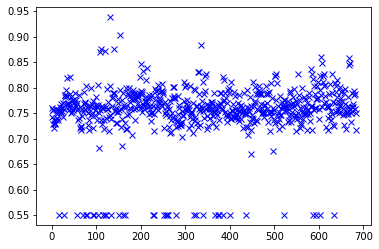


QUERY:  Is there a standalone version of the galasa.dev documentation site?

Score:    (Score: 0.9157) 

Title:   {30: 'Produce standalone version of the galasa.dev documentation site'} 

Body:   {30: 'For the closed network solutions we need standalone versions of the galasa.dev documentation.   Specifically we need:-\n\n1. A version that can run from a directory of the laptop,  point the browser at the index.html and all the docs are available\n2. A docker image running something to present the documentation to the browser from the docker container.'} 

URL:   {30: 'https://github.com/galasa-dev/projectmanagement/issues/656'} 

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

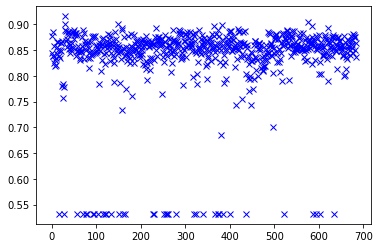


QUERY:  Has anyone moved the z/OS 3270 Manager to Beta?

Score:    (Score: 0.9141) 

Title:   {473: 'RELEASE the z/OS 3270 Manager'} 

Body:   {473: 'Perform the testing required to move the z/OS 3270 Manager to Release level.'} 

URL:   {473: 'https://github.com/galasa-dev/projectmanagement/issues/213'} 

------------------------------------------------------------------------------------------------- 

Score:    (Score: 0.9136) 

Title:   {523: 'z/OS Console Manager has only a placeholder documentation page'} 

Body:   {523: ''} 

URL:   {523: 'https://github.com/galasa-dev/projectmanagement/issues/163'} 

--------------------------------------------------------------------------------- 

Score:    (Score: 0.9102) 

Title:   {657: 'Increase CC% for the zOS 3270 Manager'} 

Body:   {657: ''} 

URL:   {657: 'https://github.com/galasa-dev/projectmanagement/issues/28'} 

---------------------------------------------------- 

Score:    (Score: 0.9088) 

Title:   {524: 'z/OS Batch Manager

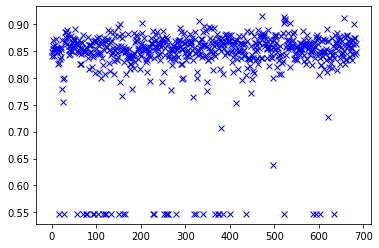

In [35]:
closest_n = 5
print("\nTOP 5 RELEVANT GITHUB ISSUES POSTS\n")

for q, q_embed in zip(queries, embedded_queries):
    distances = scipy.spatial.distance.cdist([q_embed], embedded_corpus, "cosine")[0]
    
    results = zip(range(len(distances)), distances)
    results = sorted(results, key=lambda x: x[1])

    print("\nQUERY: ",q)
    print("=" * int(1.15 * len(q)),"\n")

    for idx, distance in results[0:closest_n]:
        print("Score:   ", "(Score: %.4f)" % (1-distance) , "\n" )
        # print("Paragraph:   ", corpus[idx].strip(), "\n" )
        row_dict = test_data_frame.loc[test_data_frame.index == idx].to_dict()
        print("Title:  " , row_dict["title"] , "\n")
        print("Body:  " , row_dict["body"] , "\n")
        print("URL:  " , row_dict["html_url"] , "\n")
        print("-" * int(1.15 * max(len(str(row_dict["body"])),len(str(row_dict["title"])))),"\n")

    plt.plot(1 - distances, 'bx')
    plt.show()

